# Empirically Matching OM10 Lens Galaxies to SL2S

_Phil Marshall & Bryce Kalmbach, September 2016_

_Last Updated: Bryce Kalmbach, October 2019_

We need to be able to assign a stellar mass and size to each of our OM10 lens galaxies, so that we can, in turn, associate a suitable `cosmoDC2` galaxy with that object. To do this, we will follow Tom Holoien's "empiriciSN" approach, and model the intrinsic distribution of lens galaxy size, stellar mass, redshift and velocity dispersion with the "extreme deconvolution" algorithm.

SEDs are matched in a separate code at the bottom since `gcr-catalogs` does not have SEDs available as the old CATSIM galaxies did.


## Requirements

You will need to have installed Tom Holoien's [`XDGMM`]() and [`empiriciSN`]() packages, as well as their dependencies. 

> By default, in `empiricSN` all the model fitting is done with the [`AstroML`](http://www.astroml.org/index.html) XDGMM algorithm rather than the [Bovy et al. (2011)](https://github.com/jobovy/extreme-deconvolution) algorithm - for this demo you do not need to have the Bovy et al. algorithm installed to run the code. However, we note that the Bovy et al. algorithm is, in general, significantly (i.e., several times) faster. We recommend you try each method on your dataset when using this class.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
import corner
import urllib
import os
from sklearn.model_selection import train_test_split
from astroML.plotting import setup_text_plots
from lsst.sims.photUtils import Sed, Bandpass, BandpassDict, getImsimFluxNorm

import empiriciSN

%matplotlib inline

In [2]:
def plot_bic(param_range,bics,lowest_comp):
    plt.clf()
    setup_text_plots(fontsize=16, usetex=False)
    fig = plt.figure(figsize=(12, 6))
    plt.plot(param_range,bics,color='blue',lw=2, marker='o')
    plt.text(lowest_comp, bics.min() * 0.97 + .03 * bics.max(), '*',
             fontsize=14, ha='center')

    plt.xticks(param_range)
    plt.ylim(bics.min() - 0.05 * (bics.max() - bics.min()),
             bics.max() + 0.05 * (bics.max() - bics.min()))
    plt.xlim(param_range.min() - 1, param_range.max() + 1)

    plt.xticks(param_range,fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel('Number of components',fontsize=18)
    plt.ylabel('BIC score',fontsize=18)

    plt.show()

Set the CosmoDC2 catalog you want to use here and this will ensure consistent naming throughout all the output files created.

In [3]:
catalog_version = 'cosmoDC2_v1.1.4'

## Empirical Strong Lens Data

We'll use the SL2S sample of galaxy-scale lenses to model the properties of OM10 lenses. The redshifts and velocity dispersions should cover *most* (but not all) of the LSST lensed quasar sample in OM10.

The data is in Table 3 of [Sonnenfeld et al (2013)](https://arxiv.org/abs/1307.4759), and stored as a csv format file in the Twinkles data folder.

In [4]:
def get_sl2s_data():
    filename = '../data/SonnenfeldEtal2013_Table3.csv'
    ! wc -l $filename

    z = np.array([])
    z_err = np.array([])
    v_disp = np.array([])
    v_disp_err = np.array([])
    r_eff = np.array([])
    r_eff_err = np.array([])
    log_m = np.array([])
    log_m_err = np.array([])
    
    infile = open(filename, 'r')
    inlines = infile.readlines()
    
    for line1 in inlines:
        if line1[0] == '#': continue
        line = line1.split(',')
        
        #Params
        z = np.append(z, float(line[1]))
        v_disp = np.append(v_disp, float(line[2]))
        r_eff = np.append(r_eff, float(line[3]))
        log_m = np.append(log_m, float(line[4]))
        
        #Errors
        z_err = np.append(z_err, float(line[5]))
        v_disp_err = np.append(v_disp_err, float(line[6]))
        r_eff_err = np.append(r_eff_err, float(line[7]))
        log_m_err = np.append(log_m_err, float(line[8]))
    
    #Build final arrays
    X = np.vstack([z, v_disp, r_eff, log_m]).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    
    Xerr[:, diag, diag] = np.vstack([z_err**2, v_disp_err**2,
                                    r_eff_err**2, log_m_err**2]).T
    
    return X, Xerr

# Here's what we did to get the csv file:
# ! echo "ID, zlens, vdisp, Reff, Mstar, zlens_err, vdisp_err, Reff_err, Mstar_err" > SonnenfeldEtal2013_Table3.csv  
# ! cat gammaptable.tex | sed s%'&'%%g | sed s%'\$'%%g | sed s%'\\'%%g | sed s%'pm'%'  '%g | sed s%'disky'%%g | awk '{print $1", "$2", "$5", "$3", "$7", 0.001, "$6", 0.01, "$8}' >> SonnenfeldEtal2013_Table3.csv

## Component Test

We could fit our lens galaxy dataset directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way to determine the optimal number of Gaussian components to use in the model is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

We can test for the model with the lowest BIC score for a given dataset using the `component_test` function, which will compute the BIC for a given dataset and range of n_components and return an array containing all the BIC scores as well as the optimal number of components and corresponding BIC value. The code below will read in all the SN and host parameters we want to use from our data files (using the `get_data` function) and use these data to test the performance of the model with n_components ranging from 1 to 8. (Larger numbers of components tend to run into errors occurring because too few observations map to a given Gaussian component. With a bigger dataset, this range could be increased.)

<Note that due to the multiple fits and the large dataset, the BIC test will likely take a while to run, depending on your system.>

In [5]:
# Instantiate an empiriciSN worker object:
empiricist = empiriciSN.Empiricist()

In [6]:
# Define the range of component numbers and read in the dataset:
component_range = np.array([1,2,3,4,5,6,7,8])
X, Xerr = get_sl2s_data()

26 ../data/SonnenfeldEtal2013_Table3.csv


In [7]:
%%capture --no-stdout
# Loop over component numbers, fitting XDGMM model and computing the BIC. 

bics, optimal_n_comp, lowest_bic = empiricist.component_test(X, Xerr, component_range)

N = 1 , BIC = 404.6771676188719
N = 2 , BIC = 409.26019204591387
N = 3 , BIC = 464.43424433260486
N = 4 , BIC = 465.9430040837867
N = 5 , BIC = 500.27637903760444
N = 6 , BIC = 525.6974514792759
N = 7 , BIC = 557.5009414350593
N = 8 , BIC = 577.4664697725502


<Figure size 432x288 with 0 Axes>

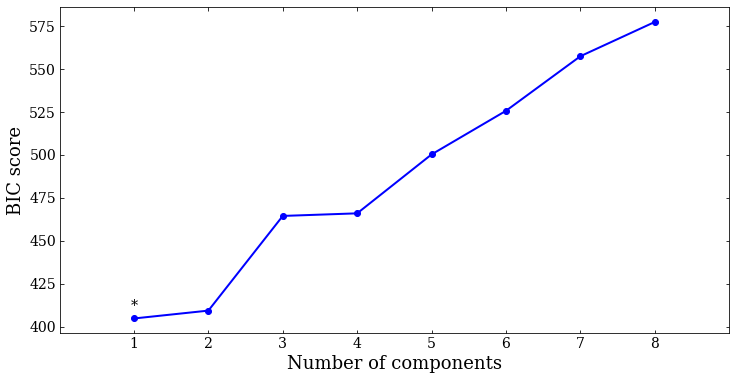

In [8]:
plot_bic(component_range, bics, optimal_n_comp)

> Based on the results of the above test, the model with 1 component has the lowest BIC score and is the optimal choice.


## Fitting a Model

Once we know how many components to use in the model, we can fit a model using that number of components using the `fit_model` function. Before fitting for this demo, we are going to split our lens galaxy dataset 65-35, with the larger subsample being used to fit the model and the smaller subsample providing a test sample that we can use to predict stellar masses and compare with our predicted sample.

In [9]:
%%capture --no-stdout
# Split the dataset 65/35:
X_train, X_test, Xerr_train, Xerr_test = \
    train_test_split(X, Xerr, test_size=0.35, random_state=17)

# Fit the model:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
#empiricist.read_model('demo_model.fit')

Note how the `fit_model` function also saves the fit to a file for later re-use. If a model has already been fit, it can be read into an existing `Empiricist` worker, or a new `Empiricist` can be instantiated using the model, like this:

In [10]:
alternative = empiriciSN.Empiricist(model_file='demo_model.fit')

# Print the weights array for each object---they should be the same...
print(empiricist.XDGMM.weights)
print(alternative.XDGMM.weights)

[1.]
[1.]


## Predicting stellar masses of lens galaxies

Our goal in this notebook is to predict the stellar masses of OM10 lens galaxies. Here we use the XDGMM model we just fit on the test data we separated off from the full dataset. We will use the model to predict stellar masses of lens galaxies based upon their redshift, velocity dispersion and radial size.

<The "test" sample generated above gives us a set of 482 host properties that we can use to fit supernovae, and a set of supernova properties to compare with our model fits.>

First, we adapt the "get_logR" function from empiriciSN to "get_log_m" changing the references and restrictions of that method (it only allows certain columns due to structure of SN dataset it uses) to suit our strong lensing dataset.

In [11]:
#Write new conditioning function
def get_log_m(cond_indices, m_index, X, model_file, Xerr=None):
    
    """
        Uses a subset of parameters in the given data to condition the
        model and return a sample value for log(M/M_sun).

        Parameters
        ----------
        cond_indices: array_like
            Array of indices indicating which parameters to use to
            condition the model. 
        m_index: int
            Index of log(M/M_sun) in the list of parameters that were used
            to fit the model.
        X: array_like, shape = (n < n_features,)
            Input data.
        Xerr: array_like, shape = (X.shape,) (optional)
            Error on input data. If none, no error used to condition.

        Returns
        -------
        log_m: float
            Sample value of log(M/M_sun) taken from the conditioned model.

        Notes
        -----
        The fit_params array specifies a list of indices to use to
        condition the model. The model will be conditioned and then
        a mass will be drawn from the conditioned model.

        This is so that the mass can be used to find cosmoDC2 galaxies
        to act as hosts for OM10 systems.

        This does not make assumptions about what parameters are being
        used in the model, but does assume that the model has been
        fit already.
    """

    if m_index in cond_indices:
        raise ValueError("Cannot condition model on log(M/M_sun).")

    cond_data = np.array([])
    if Xerr is not None: cond_err = np.array([])
    m_cond_idx = m_index
    n_features = empiricist.XDGMM.mu.shape[1]
    j = 0

    for i in range(n_features):
        if i in cond_indices:
            cond_data = np.append(cond_data,X[j])
            if Xerr is not None: cond_err = np.append(cond_err, Xerr[j])
            j += 1
            if i < m_index: m_cond_idx -= 1
        else:
            cond_data = np.append(cond_data,np.nan)
            if Xerr is not None: cond_err = np.append(cond_err, 0.0)

    if Xerr is not None:
        cond_XDGMM = empiricist.XDGMM.condition(cond_data, cond_err)
    else: cond_XDGMM = empiricist.XDGMM.condition(cond_data)

    sample = cond_XDGMM.sample()
    log_m = sample[0][m_cond_idx]
    return log_m

With that ready to go, we now use it to get estimates on the stellar mass of our test data from the model we have trained above.

In [12]:
%%capture --no-stdout
# Get actual masses from dataset, for comparison:
log_m_test = X_test[:,3]
r_test = X_test[:,2]

# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
sample_log_m = np.array([])
sample_r = np.array([])

model_file='demo_model.fit'

for x, xerr in zip(X_test, Xerr_test):
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)#, Xerr=xerr)
    sample_log_m = np.append(sample_log_m,log_m)
    print(x[3], log_m)
    
for x, xerr in zip(X_test, Xerr_test):
    r_cond = get_log_m(cond_indices, 2, x[cond_indices], model_file)#, Xerr=xerr)
    sample_r = np.append(sample_r,r_cond)
    print(x[2], r_cond)

11.76 11.331060540115132
11.45 11.43838497735066
11.6 11.47290254748502
11.28 11.164824405477713
11.81 11.200741872654891
11.14 11.488674512471457
11.26 11.443656357530793
11.51 12.243908409604185
11.53 11.759998321609174
7.86 6.258851289936219
8.92 8.052642451651487
4.35 13.736369915440756
3.04 3.371401318362056
8.59 4.619046279207095
1.35 0.5869612051862356
3.86 7.39634399642102
3.93 7.895012627661326
4.27 12.843001329238673


Now we have a set of test masses in units of log(M/M_sun) and a set of masses sampled from the model. These should have the same distribution when plotted.

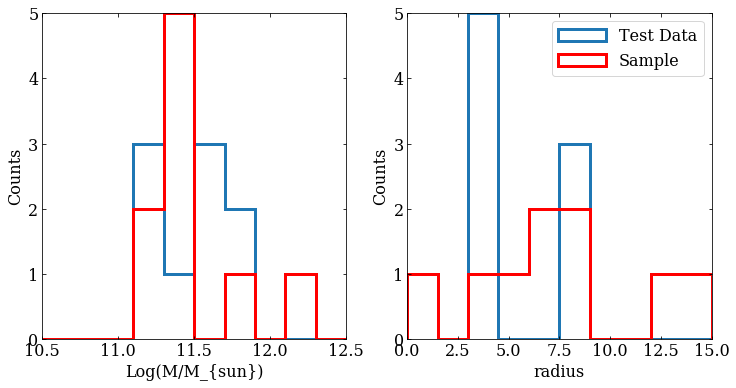

In [13]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.hist(log_m_test, 10, range=(10.5, 12.5), histtype='step', lw=3)
plt.hist(sample_log_m, 10, range=(10.5, 12.5), color ='r', histtype='step', lw=3)
plt.xlabel('Log(M/M_{sun})')
plt.ylabel('Counts')

fig.add_subplot(122)
plt.hist(r_test, 10, range=(0, 15), histtype='step', lw=3)
plt.hist(sample_r, 10, range=(0, 15), color ='r', histtype='step', lw=3)
plt.xlabel('radius')
plt.ylabel('Counts')
plt.legend(('Test Data', 'Sample'))
plt.show()

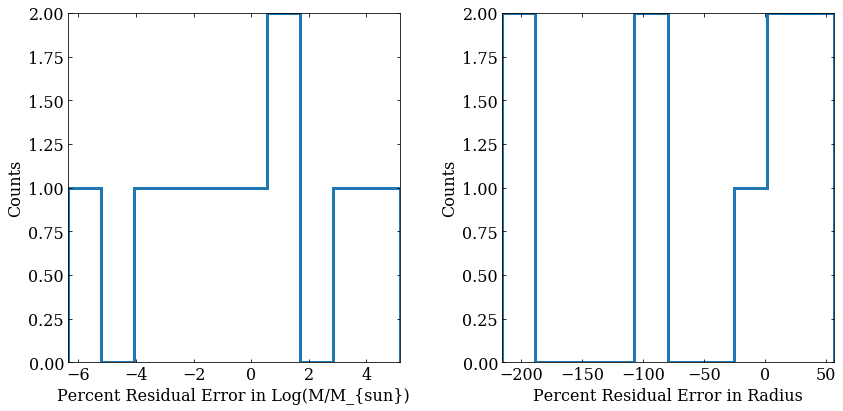

In [14]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.hist(100*(log_m_test-sample_log_m)/log_m_test, 10, histtype='step', lw=3)
plt.xlabel('Percent Residual Error in Log(M/M_{sun})')
plt.ylabel('Counts')

fig.add_subplot(122)
plt.hist(100*(r_test-sample_r)/r_test, 10, histtype='step', lw=3)
plt.xlabel('Percent Residual Error in Radius')
plt.ylabel('Counts')
plt.tight_layout()

It seems that while we can predict the stellar masses to a reasonable degree the estimates for Radius are very poor and we should get those values from cosmoDC2 while matching galaxies on just stellar mass, redshift and ellipticity. Furthermore, below we will drop the radius from the model.

The dataset has a very small amount of data and to prevent overfitting against an even smaller sample we choose to use the full dataset in training the model going forward. We want to make sure that the model gives reasonable values when generating masses, redshift and velocity dispersions. Therefore, we will sample the GMM for 1, 2 and 3 component models and take a look at the results with the training data.

In [15]:
# Drop the radius data and fit only to predict stellar mass
X = X[:,[0,1,3]]
Xerr = Xerr[:,:,[0,1,3]]
Xerr = Xerr[:,[0,1,3], :]

In [16]:
%%capture --no-stdout
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=1)
test_sample = empiricist.XDGMM.sample(size=10000)

/global/homes/b/brycek/.local/lib/python3.7/site-packages/corner/corner.py:580: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)


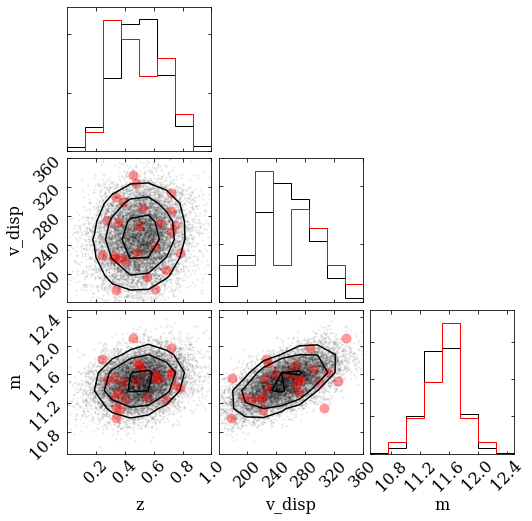

In [17]:
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'm'], bins=8,
                       range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'density': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X[:, :], labels=['z', 'v_disp', 'm'], color='red', bins=8,
              range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'density':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)

plt.show()

Here we try fitting our model with 2 components in the GMM.

In [18]:
%%capture --no-stdout
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=2)

/global/homes/b/brycek/.local/lib/python3.7/site-packages/corner/corner.py:580: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)


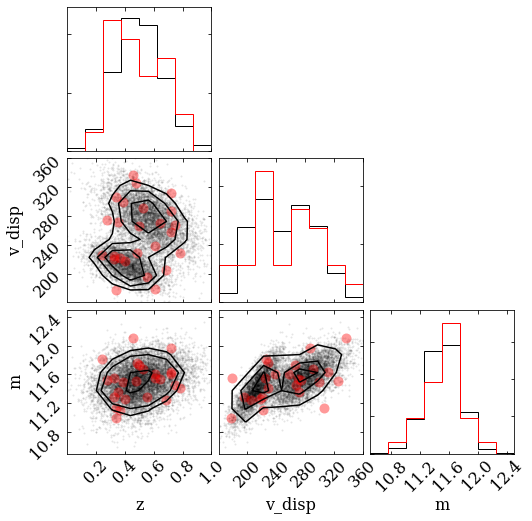

In [19]:
test_sample = empiricist.XDGMM.sample(size=10000)
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'm'], bins=8,
                       range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'density': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X[:, :], labels=['z', 'v_disp', 'm'], color='red', bins=8,
              range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'density':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)

plt.show()

And here we use 3 components.

In [20]:
%%capture --no-stdout
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=3)

/global/homes/b/brycek/.local/lib/python3.7/site-packages/corner/corner.py:580: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)


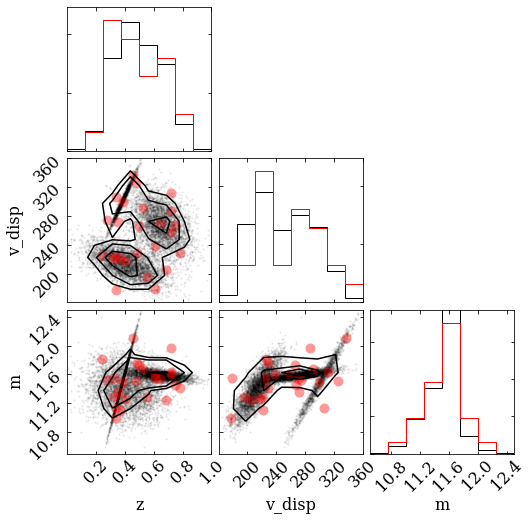

In [21]:
test_sample = empiricist.XDGMM.sample(size=10000)
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'm'], bins=8,
                       range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'density': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X[:, :], labels=['z', 'v_disp', 'm'], color='red', bins=8,
              range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'density':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)

plt.show()

### Estimating Stellar Masses for OM10 systems

We have decided to move forward and will continue comparing the 1, 2, and 3 parameter GMM models. We will now use the available data in OM10 sytems to find a stellar mass for OM10 systems based upon redshift and velocity dispersion. Since our attempts to predict radius seem to be inaccurate we will get radius estimate from cosmoDC2 galaxies as well and thus only will be predicting stellar masses for OM10 lenses here.

In [22]:
# First load in OM10 lenses we are using in Twinkles

from astropy.io import fits
hdulist = fits.open('../data/om10_qso_mock.fits')
twinkles_lenses = hdulist[1].data

#### Cut out AGN higher that z=3.1 limit of cosmoDC2 galaxies

In [23]:
# Only keep z <= 3.1 systems because cosmoDC2 only goes out to redshift of ~3.1
twinkles_lenses = twinkles_lenses[np.where(twinkles_lenses['ZSRC'] <= 3.1)]

In [25]:
%%capture --no-stdout
    # Predict a mass for each galaxy:
    np.random.seed(0)
    cond_indices = np.array([0,1])
    twinkles_log_m_1comp = np.array([])
    twinkles_log_m_2comp = np.array([])
    twinkles_log_m_3comp = np.array([])

    model_file='demo_model.fit'
    empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=1)
    twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

    for x in twinkles_data:
        log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
        twinkles_log_m_1comp = np.append(twinkles_log_m_1comp,log_m)
    
    np.random.seed(0)

    empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=2)
    twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

    for x in twinkles_data:
        log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
        twinkles_log_m_2comp = np.append(twinkles_log_m_2comp,log_m)

    np.random.seed(0)

    empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=3)
    twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

    for x in twinkles_data:
        log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
        twinkles_log_m_3comp = np.append(twinkles_log_m_3comp,log_m)

Below we compare the distributions of stellar mass given to the OM10 lens galaxies by the 1, 2 and 3 component models.

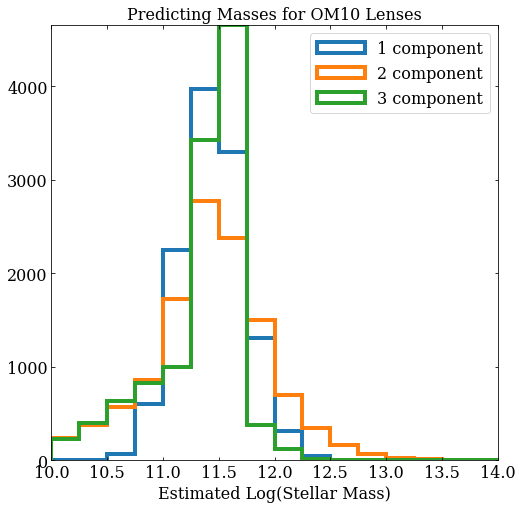

In [26]:
fig = plt.figure(figsize=(8,8))
mpl.rcParams['text.usetex'] = False
n, bins, _ = plt.hist(twinkles_log_m_1comp, histtype='step', label='1 component', range=(10, 14), lw=4, bins=16)
plt.hist(twinkles_log_m_2comp, histtype='step', label='2 component', bins=bins, lw=4)
plt.hist(twinkles_log_m_3comp, histtype='step', label='3 component', bins=bins, lw=4)
plt.xlabel('Estimated Log(Stellar Mass)')
plt.title('Predicting Masses for OM10 Lenses')
plt.legend()

Now we connect to the cosmoDC2 database and use redshift, stellar_mass and ellipticity of our OM10 galaxies to find associated radial sizes for our galaxies. The query looks for any galaxies within 10% in dex of redshift and 10% of stellar mass and ellipticity. For our lens galaxies we don't want disks. However, limiting ourselves in cosmoDC2 to only galaxies with `stellar_mass_disk` == 0.0 was too restrictive and we instead take the bulge properties for galaxies where the stellar mass of the bulge is over 99% of the total stellar mass. If no matches are found then it will skip on to the next system and we will leave that OM10 system out of the catalog available to the sprinkler.

In [27]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

In [28]:
# _small is a representative sample and will be faster to match against
catalog = GCRCatalogs.load_catalog(str(catalog_version + '_small'))

In [29]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m_1comp = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=1)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m_1comp = np.append(twinkles_log_m_1comp,log_m)

In [30]:
%%time
gcr_om10_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(twinkles_lenses['ZLENS'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(twinkles_lenses['ZLENS'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m_1comp))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m_1comp))*1.1

data = catalog.get_quantities(['galaxy_id', 'redshift', 'redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['om10_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)
print(data_df.head(10))

   size_minor_true  redshift_true  stellar_mass  ellipticity_true  \
0         6.739718       0.042616  1.176504e+11          0.002713   
1         0.928754       0.116293  1.204609e+11          0.190765   
2         1.010811       0.126486  3.390940e+10          0.005936   
3         2.893876       0.103823  3.169465e+11          0.112284   
4         2.331435       0.103823  2.155272e+11          0.037030   
5         0.647623       0.109586  5.708047e+10          0.202137   
6         2.855348       0.115771  1.276335e+11          0.030482   
7         0.534622       0.140519  4.490443e+10          0.066086   
8         1.707973       0.132717  1.716955e+11          0.008951   
9         1.565895       0.131990  3.298847e+10          0.009021   

   size_bulge_true  redshift  size_true  stellar_mass_bulge  \
0         6.765470  0.043612   6.776393        1.175006e+11   
1         1.364272  0.114301   1.366634        1.204372e+11   
2         1.013157  0.125086   1.022883        3.35

In [31]:
len(data_df)

1001923

In [32]:
%%time
row_num = -1
keep_rows = []

for zsrc, m_star, ellip in zip(twinkles_lenses['ZLENS'], np.power(10, twinkles_log_m_1comp), twinkles_lenses['ELLIP']):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 1000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and om10_ellipticity > %f and om10_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift'].values[0],
                    data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['om10_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0],
                    data_subset['galaxy_id'].values[0]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift'].values[use_idx],
                    data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['om10_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m_1comp))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
Total Match Failures:  502  Percentage Match Failures:  0.04230574751390528
CPU times: user 3min 8s, sys: 218 ms, total: 3min 8s
Wall time: 3min 9s


In [33]:
gcr_z_1comp = []
gcr_z_true_1comp = []
gcr_m_star_1comp = []
gcr_r_eff_1comp = []
gcr_gal_id_1comp = []
for row in gcr_om10_match:
    gcr_z_1comp.append(row[0])
    gcr_z_true_1comp.append(row[1])
    gcr_m_star_1comp.append(row[2])
    gcr_r_eff_1comp.append(np.sqrt(row[4]*row[5]))
    gcr_gal_id_1comp.append(row[6])
np.savetxt('keep_rows_agn.dat', np.array(keep_rows))

Text(0.5, 1.0, '1 component model redshift matching')

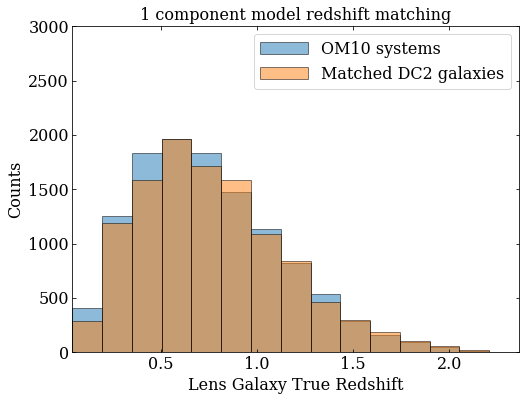

In [34]:
#Let's take a look at a couple results
fig = plt.figure(figsize=(8,6))
n, bins, p = plt.hist(twinkles_lenses['ZLENS'], alpha=0.5, bins=15, label='OM10 systems')
plt.hist(gcr_z_true_1comp, alpha=0.5, bins=bins, label='Matched DC2 galaxies')
plt.xlabel('Lens Galaxy True Redshift')
plt.ylabel('Counts')
plt.ylim(0, 3000)
plt.legend()
plt.title('1 component model redshift matching')

Text(0.5, 1.0, '1 component model mass matching')

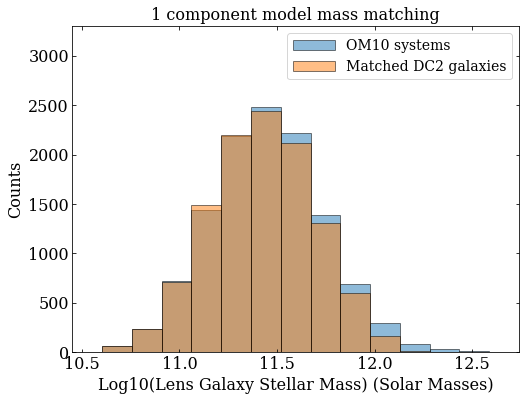

In [35]:
#Let's take a look at a couple results
fig = plt.figure(figsize=(8,6))
n, bins, p = plt.hist(twinkles_log_m_1comp, alpha=0.5, bins=15, label='OM10 systems')#, range=(0,100))
plt.hist(np.log10(gcr_m_star_1comp), alpha=0.5, bins=bins, label='Matched DC2 galaxies')
plt.xlabel('Log10(Lens Galaxy Stellar Mass) (Solar Masses)')
plt.ylabel('Counts')
plt.ylim(0, 3300)
plt.legend(fontsize=14)
plt.title('1 component model mass matching')

We are able to match over 95% of the systems, but it seems that this disproportionately leaves out very high masses. Let's see if the 3-component model can do better.

In [36]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=3)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)

In [37]:
%%time
gcr_om10_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(twinkles_lenses['ZLENS'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(twinkles_lenses['ZLENS'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m))*1.1

data = catalog.get_quantities(['galaxy_id', 'redshift', 'redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['om10_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)
print(data_df.head(10))

row_num = -1
keep_rows = []

for zsrc, m_star, ellip in zip(twinkles_lenses['ZLENS'], np.power(10, twinkles_log_m), twinkles_lenses['ELLIP']):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 1000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and om10_ellipticity > %f and om10_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift'].values[0],
                    data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['om10_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0],
                    data_subset['galaxy_id'].values[0]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift'].values[use_idx],
                    data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['om10_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m))

   size_minor_true  redshift_true  stellar_mass  ellipticity_true  \
0         1.030906       0.047006  1.920787e+09          0.105313   
1         6.739718       0.042616  1.176504e+11          0.002713   
2         1.127700       0.088871  1.360790e+10          0.042205   
3         0.621940       0.077235  7.996274e+09          0.082510   
4         1.326249       0.091847  4.707678e+09          0.025211   
5         0.493954       0.114011  5.592710e+09          0.009531   
6         0.928754       0.116293  1.204609e+11          0.190765   
7         0.851696       0.125303  1.453536e+10          0.057357   
8         1.010811       0.126486  3.390940e+10          0.005936   
9         2.893876       0.103823  3.169465e+11          0.112284   

   size_bulge_true  redshift  size_true  stellar_mass_bulge  \
0         1.264354  0.047481   1.273600        1.915029e+09   
1         6.765470  0.043612   6.776393        1.175006e+11   
2         1.178880  0.088792   1.227085        1.35

In [38]:
gcr_z = []
gcr_z_true = []
gcr_m_star = []
for row in gcr_om10_match:
    gcr_z.append(row[0])
    gcr_z_true.append(row[1])
    gcr_m_star.append(row[2])

Text(0.5, 1.0, '3 component model redshift matching')

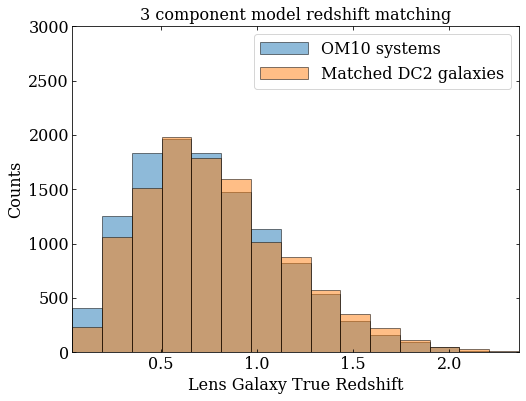

In [39]:
fig = plt.figure(figsize=(8,6))
n, bins, p = plt.hist(twinkles_lenses['ZLENS'], alpha=0.5, bins=15, label='OM10 systems')
plt.hist(gcr_z_true, alpha=0.5, bins=bins, label='Matched DC2 galaxies')
plt.xlabel('Lens Galaxy True Redshift')
plt.ylabel('Counts')
plt.ylim(0, 3000)
plt.legend()
plt.title('3 component model redshift matching')

Text(0.5, 1.0, '3 component model stellar mass matching')

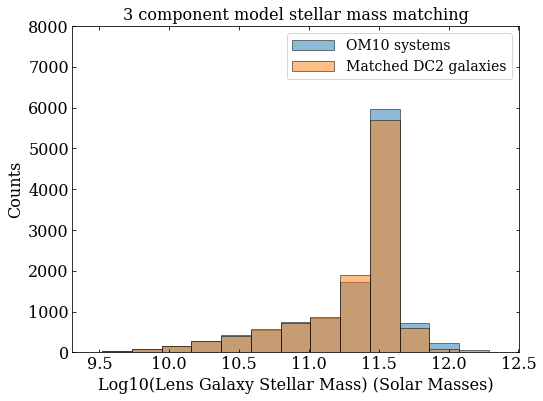

In [40]:
#Let's take a look at a couple results
fig = plt.figure(figsize=(8,6))
n, bins, p = plt.hist(twinkles_log_m, alpha=0.5, bins=15, label='OM10 systems')#, range=(0,100))
plt.hist(np.log10(gcr_m_star), alpha=0.5, bins=bins, label='Matched DC2 galaxies')
plt.xlabel('Log10(Lens Galaxy Stellar Mass) (Solar Masses)')
plt.ylabel('Counts')
plt.ylim(0, 8000)
plt.legend(fontsize=14)
plt.title('3 component model stellar mass matching')

The matching is now available in over 96% of the OM10 catalog but overall doesn't seem to make much of a difference at the high mass end. Since the distribution for the 3 component model seems to be unrealistic and doesn't add much improvement let's see if we can get a reasonable improvement on the 1 component results using a 2 component model.

In [41]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=2)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)

/global/homes/b/brycek/.local/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [42]:
%%time
gcr_om10_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(twinkles_lenses['ZLENS'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(twinkles_lenses['ZLENS'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m))*1.1

data = catalog.get_quantities(['galaxy_id', 'redshift', 'redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['om10_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)
print(data_df.head(10))

row_num = -1
keep_rows = []

for zsrc, m_star, ellip in zip(twinkles_lenses['ZLENS'], np.power(10, twinkles_log_m), twinkles_lenses['ELLIP']):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 1000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and om10_ellipticity > %f and om10_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift'].values[0],
                    data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['om10_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0],
                    data_subset['galaxy_id'].values[0]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift'].values[use_idx],
                    data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['om10_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m))

   size_minor_true  redshift_true  stellar_mass  ellipticity_true  \
0         6.739718       0.042616  1.176504e+11          0.002713   
1         1.127700       0.088871  1.360790e+10          0.042205   
2         0.621940       0.077235  7.996274e+09          0.082510   
3         1.326249       0.091847  4.707678e+09          0.025211   
4         0.493954       0.114011  5.592710e+09          0.009531   
5         0.928754       0.116293  1.204609e+11          0.190765   
6         0.851696       0.125303  1.453536e+10          0.057357   
7         1.010811       0.126486  3.390940e+10          0.005936   
8         2.893876       0.103823  3.169465e+11          0.112284   
9         2.331435       0.103823  2.155272e+11          0.037030   

   size_bulge_true  redshift  size_true  stellar_mass_bulge  \
0         6.765470  0.043612   6.776393        1.175006e+11   
1         1.178880  0.088792   1.227085        1.355794e+10   
2         0.697619  0.076727   0.733803        7.94

In [44]:
gcr_z = []
gcr_z_true = []
gcr_m_star = []
for row in gcr_om10_match:
    gcr_z.append(row[0])
    gcr_z_true.append(row[1])
    gcr_m_star.append(row[2])

Text(0.5, 1.0, '2 component model true redshift matching')

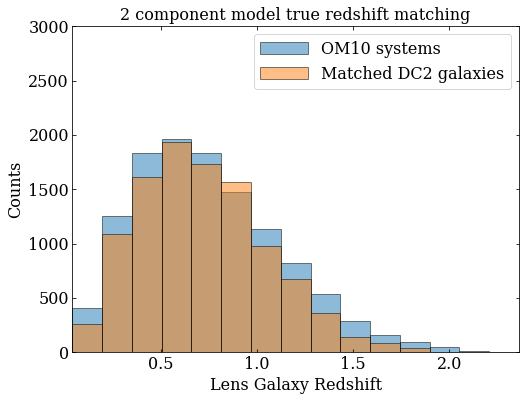

In [45]:
fig = plt.figure(figsize=(8,6))
n, bins, p = plt.hist(twinkles_lenses['ZLENS'], alpha=0.5, bins=15, label='OM10 systems')
plt.hist(gcr_z_true, alpha=0.5, bins=bins, label='Matched DC2 galaxies')
plt.xlabel('Lens Galaxy Redshift')
plt.ylabel('Counts')
plt.ylim(0, 3000)
plt.legend()
plt.title('2 component model true redshift matching')

Text(0.5, 1.0, '2 component model stellar mass matching')

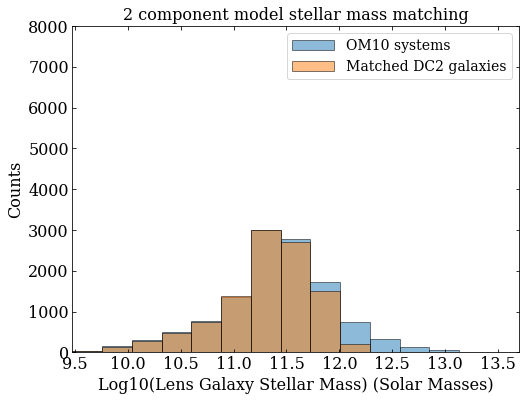

In [46]:
#Let's take a look at a couple results
fig = plt.figure(figsize=(8,6))
n, bins, p = plt.hist(twinkles_log_m, alpha=0.5, bins=15, label='OM10 systems')#, range=(0,100))
plt.hist(np.log10(gcr_m_star), alpha=0.5, bins=bins, label='Matched DC2 galaxies')
plt.xlabel('Log10(Lens Galaxy Stellar Mass) (Solar Masses)')
plt.ylabel('Counts')
plt.ylim(0, 8000)
plt.legend(fontsize=14)
plt.title('2 component model stellar mass matching')

This does the worst of the 3 models. Therefore, it looks like we should use the **1-component** model for the final match to the catalog.

## Matching to SEDs using `sims_GCRCatSimInterface`

The other thing we want to add into the lensing catalogs are SEDs for the lens galaxies. Here we get the top hat filters out of cosmoDC2 and use the code in `sims_GCRCatSimInterface` to match these values to a CATSIM SED file in the same way the galaxies are matched for Instance Catalog production in DC2. We also use the code to calculate the magnitude normalization for PhoSim.

In [47]:
import sys
sys.path.append('/global/homes/b/brycek/DC2/sims_GCRCatSimInterface/workspace/sed_cache/')

In [48]:
from SedFitter import sed_from_galacticus_mags

In [49]:
H0 = catalog.cosmology.H0.value
Om0 = catalog.cosmology.Om0

In [50]:
sed_label = []
sed_min_wave = []
sed_wave_width = []
for quant_label in sorted(catalog.list_all_quantities()):
    if (quant_label.startswith('sed') and quant_label.endswith('bulge')):
        sed_label.append(quant_label)
        label_split = quant_label.split('_')
        sed_min_wave.append(int(label_split[1])/10)
        sed_wave_width.append(int(label_split[2])/10)
bin_order = np.argsort(sed_min_wave)
sed_label = np.array(sed_label)[bin_order]
sed_min_wave = np.array(sed_min_wave)[bin_order]
sed_wave_width = np.array(sed_wave_width)[bin_order]

Check to see that our bins are now in order when we call them.

In [51]:
for i in zip(sed_label, sed_min_wave, sed_wave_width):
    print(i)

('sed_1000_246_bulge', 100.0, 24.6)
('sed_1246_306_bulge', 124.6, 30.6)
('sed_1552_381_bulge', 155.2, 38.1)
('sed_1933_474_bulge', 193.3, 47.4)
('sed_2407_591_bulge', 240.7, 59.1)
('sed_2998_186_bulge', 299.8, 18.6)
('sed_3184_197_bulge', 318.4, 19.7)
('sed_3381_209_bulge', 338.1, 20.9)
('sed_3590_222_bulge', 359.0, 22.2)
('sed_3812_236_bulge', 381.2, 23.6)
('sed_4048_251_bulge', 404.8, 25.1)
('sed_4299_266_bulge', 429.9, 26.6)
('sed_4565_283_bulge', 456.5, 28.3)
('sed_4848_300_bulge', 484.8, 30.0)
('sed_5148_319_bulge', 514.8, 31.9)
('sed_5467_339_bulge', 546.7, 33.9)
('sed_5806_360_bulge', 580.6, 36.0)
('sed_6166_382_bulge', 616.6, 38.2)
('sed_6548_406_bulge', 654.8, 40.6)
('sed_6954_431_bulge', 695.4, 43.1)
('sed_7385_458_bulge', 738.5, 45.8)
('sed_7843_486_bulge', 784.3, 48.6)
('sed_8329_517_bulge', 832.9, 51.7)
('sed_8846_549_bulge', 884.6, 54.9)
('sed_9395_583_bulge', 939.5, 58.3)
('sed_9978_1489_bulge', 997.8, 148.9)
('sed_11467_1710_bulge', 1146.7, 171.0)
('sed_13177_1966_bulge

In [52]:
del(data)
del(data_df)

In [53]:
keep_rows_1comp = np.genfromtxt('keep_rows_agn.dat')

In [54]:
keep_rows_1comp = np.array(keep_rows_1comp, dtype=int)

In [55]:
print(keep_rows_1comp)

[    1     2     4 ... 11863 11864 11865]


In [56]:
columns = ['galaxy_id', 'redshift_true', 'redshift', 'mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst',
           'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst']
for sed_bin in sed_label:
    columns.append(sed_bin)
data = catalog.get_quantities(columns,
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])
data_df = pd.DataFrame(data)

In [57]:
%%time
sed_name_list = []
magNorm_list = []
lsst_mags = []
mag_30_list = []
redshift_true_list = []
redshift_list = []
i = 0
# Using 1-component model results
for gal_id, gal_z, gal_z_true in zip(gcr_gal_id_1comp, gcr_z_1comp, gcr_z_true_1comp):
    
    if i % 1000 == 0:
        print(i)
    i+=1
    
    data_subset = data_df.query(str('galaxy_id == %i' % gal_id)) 
    mag_array = []
    lsst_mag_array = [data_subset['mag_%s_lsst' % band_name].values[0] for band_name in ['u', 'g', 'r', 'i', 'z', 'y']]
    for sed_bin in sed_label:
        mag_array.append(-2.5*np.log10(data_subset[sed_bin].values[0]))
    mag_array = np.array(mag_array)
    lsst_mag_array = np.array(lsst_mag_array)
    lsst_mags.append(lsst_mag_array)
    mag_30_list.append(mag_array)
    redshift_list.append(gal_z)
    redshift_true_list.append(gal_z_true)
print(len(sed_name_list), len(keep_rows_1comp))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
0 11364
CPU times: user 3min 27s, sys: 438 ms, total: 3min 27s
Wall time: 3min 27s


In [58]:
mag_30_list = np.array(mag_30_list).T
lsst_mags = np.array(lsst_mags).T
redshift_list = np.array(redshift_list)

In [59]:
sed_name, magNorm, av, rv = sed_from_galacticus_mags(mag_30_list, redshift_list, redshift_true_list,
                                                               H0, Om0, sed_min_wave, sed_wave_width, lsst_mags)
sed_name_list = sed_name
magNorm_list = magNorm
print(len(sed_name_list), len(keep_rows_1comp))

11364 11364


In [60]:
sed_name_array = np.array(sed_name_list)
magNorm_array = np.array(magNorm_list)
av_array = np.array(av)
rv_array = np.array(rv)

In [61]:
np.shape(av_array), np.shape(rv_array)

((11364,), (11364,))

Before saving our new information we want to check that the SEDs we are matching are in fact old, metal-poor templates. So we take the metallicity and age from all the templates and check them out.

In [62]:
sed_metals = []
sed_ages = []
sed_metals_dict = {'0005Z':'.005', '002Z':'.02', '02Z':'.2', '04Z':'.4', '1Z':'1.0', '25Z':'2.5'}
for sed_template in sed_name_array:
    sed_info = sed_template.split('/')[1].split('.')
    sed_age_info = sed_info[1].split('E')
    sed_ages.append(np.power(10, int(sed_age_info[1]))*int(sed_age_info[0]))
    sed_metals.append(sed_metals_dict[sed_info[2]])

Text(0.5, 0.98, 'Age and Metallicity of matched SED templates')

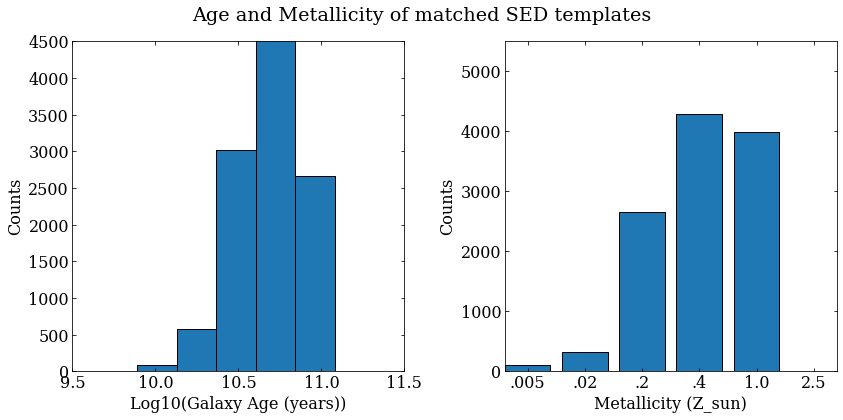

In [63]:
fig = plt.figure(figsize=(12, 6))
mpl.rcParams['text.usetex'] = False
fig.add_subplot(1,2,1)
plt.hist(np.log10(sed_ages))
plt.xlabel('Log10(Galaxy Age (years))')
plt.ylabel('Counts')
plt.ylim(0, 4500)
plt.xlim(9.5, 11.5)
fig.add_subplot(1,2,2)
names, counts = np.unique(sed_metals, return_counts=True)
x = np.arange(len(names), dtype=int)
plt.bar(x, counts)
plt.xticks(x, names)
plt.xlabel('Metallicity (Z_sun)')
plt.ylabel('Counts')
plt.ylim(0, 5500)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Age and Metallicity of matched SED templates')

It seems that we are indeed getting templates for older galaxies and mostly less than solar metallicity.

## Adding new info to Twinkles OM10 data

We will take all the columns currently in the twinkles om10 data and add in our new reff values, SED filenames and SED magnitude normalizations.

In [64]:
test_bandpassDict = BandpassDict.loadTotalBandpassesFromFiles()
imsimband = Bandpass()
imsimband.imsimBandpass()

In [65]:
mag_norm_om10 = []
test_sed = Sed()
test_sed.readSED_flambda(os.path.join(str(os.environ['SIMS_SED_LIBRARY_DIR']), sed_name_array[0]))
a, b = test_sed.setupCCM_ab()

# We need to adjust the magNorms of the galaxies so that,
# in the i-band, they match the OM10 APMAG_I.
# We do this be calculating the i-magnitudes of the galaxies as they
# will be simulated, finding the difference between that magnitude
# and APMAG_I, and adding that difference to *all* of the magNorms
# of the galaxy (this way, the cosmoDC2 validated colors of the
# galaxies are preserved)

for i, idx in list(enumerate(keep_rows_1comp)):
    if i % 10000 == 0:
        print(i, idx)
    test_sed = Sed()
    test_sed.readSED_flambda(os.path.join(str(os.environ['SIMS_SED_LIBRARY_DIR']), sed_name_array[i]))
    fnorm = getImsimFluxNorm(test_sed, magNorm_array[3,i])
    test_sed.multiplyFluxNorm(fnorm)
    test_sed.addDust(a, b, A_v=av_array[i], R_v=rv_array[i])
    test_sed.redshiftSED(twinkles_lenses['ZLENS'][idx], dimming=True)
    i_mag = test_sed.calcMag(test_bandpassDict['i'])
    d_mag = twinkles_lenses['APMAG_I'][idx]-i_mag
    mag_norm_om10.append(magNorm_array[:,i] + d_mag)

0 1
10000 10455


In [66]:
col_list = []
for col in twinkles_lenses.columns:
    if col.name != 'REFF':
        col_list.append(fits.Column(name=col.name, format=col.format, array=twinkles_lenses[col.name][keep_rows_1comp]))
    else:
        col_list.append(fits.Column(name=col.name, format=col.format, array=gcr_r_eff_1comp))
col_list.append(fits.Column(name='lens_sed', format='40A', array=sed_name_array))
col_list.append(fits.Column(name='sed_magNorm', format='6D', array=mag_norm_om10))
col_list.append(fits.Column(name='lens_av', format='D', array=av_array))
col_list.append(fits.Column(name='lens_rv', format='D', array=rv_array))

In [67]:
cols = fits.ColDefs(col_list)

In [68]:
tbhdu = fits.BinTableHDU.from_columns(cols)

In [70]:
tbhdu.writeto('../data/twinkles_lenses_%s.fits' % catalog_version)

Great! Now that we have saved our new lens catalog we can open it up and make sure the data is where we want it.

In [71]:
hdulist_2 = fits.open('../data/twinkles_lenses_%s.fits' % catalog_version)

In [72]:
print(hdulist_2[1].data[0])
print(hdulist_2[1].data['REFF'][0], hdulist_2[1].data['lens_sed'][0], hdulist_2[1].data['sed_magNorm'][0],
      hdulist_2[1].data['lens_av'][0], hdulist_2[1].data['lens_rv'][0])
print(gcr_r_eff_1comp[0], sed_name_list[0], mag_norm_om10[0], av_array[0], rv_array[0])

(34331, 0, 2, 0.084, 172.5838, 0.3209525, 154.4568, 0.06519084, 135.9098, 1.89, 0.3275911, -0.2698931, 22.09, 21.40345, 1.788124, array([ 1.0769, -0.2845,  0.    ,  0.    ]), array([-0.8203,  0.339 ,  0.    ,  0.    ]), array([ 1.882 , -2.0925,  0.    ,  0.    ]), array([0.  , 7.92, 0.  , 0.  ]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), 325.486664, 382.465057, -21.7644787, 16.2324791, 0.0839999989, 1735.9, 1613.81, 0.0, 14498.4, 0.0, 1.5672656297683716, 0.0, 'galaxySED/Burst.12E10.04Z.spec.gz', array([17.29319801, 17.17145093, 17.11936651, 17.10711868, 17.1108227 ,
       17.03407925]), 0.0, 2.0)
1.5672656297683716 galaxySED/Burst.12E10.04Z.spec.gz [17.29319801 17.17145093 17.11936651 17.10711868 17.1108227  17.03407925] 0.0 2.0
1.5672656 galaxySED/Burst.12E10.04Z.spec.gz [17.29319801 17.17145093 17.11936651 17.10711868 17.1108227  17.03407925] 0.0 2.0


Looks good!